In [1]:
import pandas as pd
import numpy as np
import xgboost
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\dani9510\AppData\Local\ESRI\conda\envs\venv\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load the training set
df = pd.read_csv('utah_tset.csv')

In [3]:
# Convert ROUTE_DIR into a binary variable, for whatever it's worth. Need to change this to avg road orientation instead
df['ROUTE_DIR'] = pd.get_dummies(df['ROUTE_DIR'])

# Continuous Features
These are currently:
* Severity Density (KDE estimate)
* Speed Limit (if available)
* Sinuosity (Road curavture metric)
* AADT2010-2015 (Annual Average Daily Traffic)

In [4]:
float_features = df.xs(['SeverityDe',
                        'SpeedLimit',
                        'Sinuosity',
                        'AADT2010',
                        'AADT2011',
                        'AADT2012',
                        'AADT2013',
                        'AADT2014',
                        'AADT2015'],axis=1).values

# Not using sklearn's scaler because I have a bunch of missing data and was feeling lazy. :)
mean_float = np.nanmean(float_features,axis=0)
std_float = np.nanstd(float_features,axis=0)

float_scaled = (float_features - mean_float) / std_float

# Temporal Features
These are important. I went back and forth on one-hot encoding vs treating them as continuous values. It didn't seem to make much difference so I'm leaving them at numbers.

In [5]:
# We can one hot encode the time values, but I've found this to be unneccesary in this case. 
time_features = df.xs(['hour','weekday','month'],axis=1)
#ohe = OneHotEncoder(sparse=False)
#time_features = ohe.fit_transform(time_features)

In [6]:
other_features = df.xs(['ROUTE_DIR',],axis=1).values

In [7]:
X = np.hstack((time_features,float_scaled,other_features))
y = df['target'].values

In [8]:
feature_names = ['hour',
                 'weekday',
                 'month',
                 'severity_density',
                 'SpeedLimit',
                 'Sinuosity',
                 'AADT2010',
                 'AADT2011',
                 'AADT2012',
                 'AADT2013',
                 'AADT2014',
                 'AADT2015',
                 'ROUTE_DIR']


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

X_train = xgboost.DMatrix(X_train,label=y_train,feature_names=feature_names)
X_test =  xgboost.DMatrix(X_test,label=y_test,feature_names=feature_names)


In [12]:
params = {
    'max_depth':50,
    'n_estimators': 107,
    'objective':'binary:logistic',
    'lambda': 1.,
    'alpha': 0,
    'silent': 0
}
skf = StratifiedKFold(n_splits=3)

for train_index, test_index in skf.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    d_x_train = xgboost.DMatrix(X_train,label=y_train,feature_names=feature_names)
    d_x_test =  xgboost.DMatrix(X_test,label=y_test,feature_names=feature_names)
    
    booster = xgboost.train(params,d_x_train)
    
    y_pred_test = np.round(booster.predict(d_x_test))
    print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
    print ('Test F1:',f1_score(y_test,y_pred_test))
    print ('Test Precision:',precision_score(y_test,y_pred_test))
    print ('Test Recall:',recall_score(y_test,y_pred_test))
    y_pred_test = booster.predict(d_x_test)
    print ('Test AUC:',roc_auc_score(y_test,y_pred_test))

    y_pred_train = np.round(booster.predict(d_x_train))
    print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
    print ('Train F1:',f1_score(y_train,y_pred_train))
    print ('Train Precision:',precision_score(y_train,y_pred_train))
    print ('Train Recall:',recall_score(y_train,y_pred_train))
    y_pred_train = booster.predict(d_x_train)
    print ('Train AUC:',roc_auc_score(y_train,y_pred_train))

Test Accuracy: 0.950937309897
Test F1: 0.893470402169
Test Precision: 0.977162136476
Test Recall: 0.822983703135
Test AUC: 0.977358461165
Train Accuracy: 0.989563322447
Train F1: 0.978694722394
Train Precision: 0.999374303913
Train Recall: 0.958853616367
Train AUC: 0.997480606325
Test Accuracy: 0.954061009189
Test F1: 0.901222403415
Test Precision: 0.974394998093
Test Recall: 0.838272019979
Test AUC: 0.978972377343
Train Accuracy: 0.987421157109
Train F1: 0.974224500256
Train Precision: 0.998751502821
Train Recall: 0.950873275062
Train AUC: 0.997204408226
Test Accuracy: 0.95606409887
Test F1: 0.905501372976
Test Precision: 0.979359463737
Test Recall: 0.842002049115
Test AUC: 0.980508760206
Train Accuracy: 0.98784738898
Train F1: 0.975108105339
Train Precision: 0.999227170014
Train Recall: 0.95212595652
Train AUC: 0.997107003962


In [ ]:
metrics = {
    'Accuracy': accuracy_score,
    'F1': f1_score,
    'Precision': precision_score,
    'Recall': recall_score,
}

In [11]:
def xg_fit(alg,X,y,feature_names,nfold=5,early_stopping_rounds=50,cv=False):
    if cv:
        xgb_param = alg.get_xgb_params()
    
        d_train = xgboost.DMatrix(X,label=y,feature_names=feature_names)
    
        cv_result = xgboost.cv(xgb_param, d_train, num_boost_round=alg.get_params()['n_estimators'], nfold=nfold,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
    
        # Result from cross validation
        alg.set_params(n_estimators=cv_result.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y, eval_metric='auc')
        
    #Predict training set:
    y_pred = alg.predict(X)
    y_probs = alg.predict_proba(X)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : {}".format(accuracy_score(y, y_pred)))
    print("Precision : {}".format(precision_score(y, y_pred)))
    print("Recall : {}".format(recall_score(y, y_pred)))
    print("F1 : {}".format(f1_score(y, y_pred)))
    print("AUC Score (Train): {}".format(roc_auc_score(y, y_probs)))
                    

In [ ]:
xg = xgboost.XGBClassifier(
    n_estimators = 1000
)

_, XN, _, yN = train_test_split(X, y, test_size=0.1, random_state=42)

xg_fit(xg,XN,yN,feature_names,cv=True)


In [15]:
g_params = {
     'max_depth':range(3,50,4),
}

_, XN, _, yN = train_test_split(X, y, test_size=0.01, random_state=42)
print (XN.shape)
gsearch = GridSearchCV(
    estimator=xgboost.XGBClassifier(
        n_estimators=107, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1, 
        seed=27), 
     param_grid=g_params, 
     scoring='recall',n_jobs=4,iid=False, cv=3)
gsearch.fit(XN,yN)
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

(14992, 53)


KeyboardInterrupt: 

In [34]:
y_pred_test = np.round(booster.predict(X_test))
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(X_test)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))

y_pred_train = np.round(booster.predict(X_train))
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(X_train)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))

AttributeError: 'numpy.ndarray' object has no attribute 'feature_names'

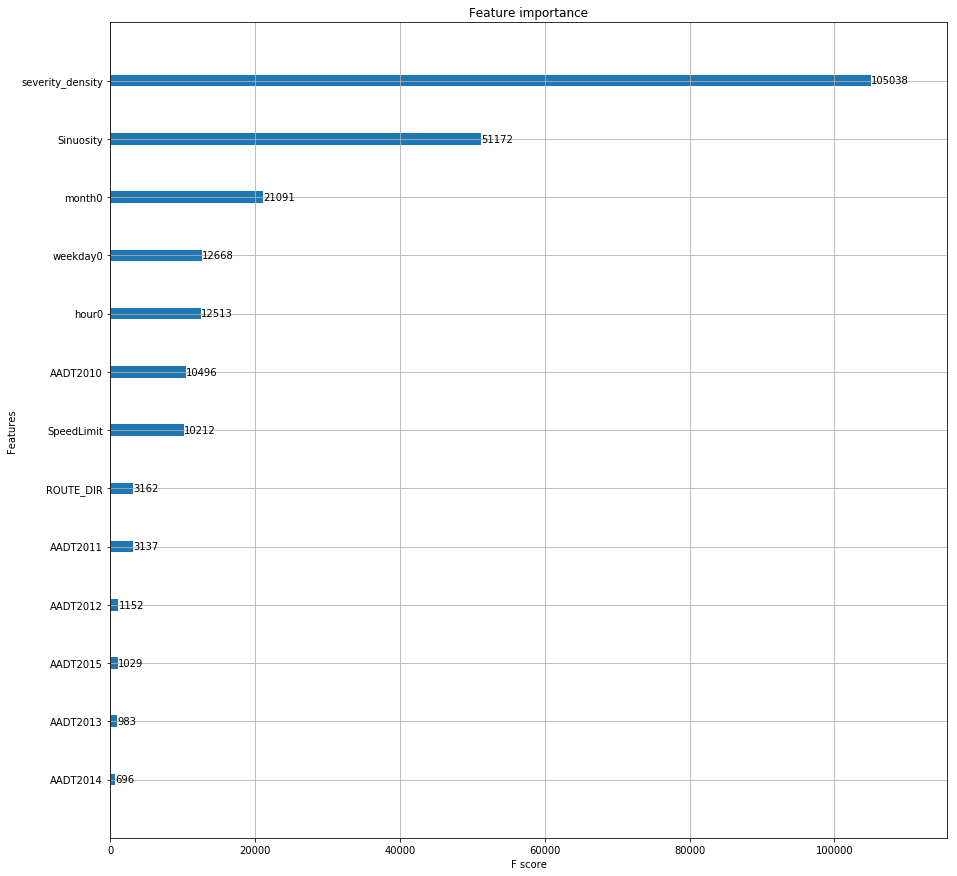

In [35]:
plt.figure(figsize=(15,15))
xgboost.plot_importance(booster,ax=plt.gca())

In [ ]:
plt.figure(figsize=(50,50))
xgboost.plot_tree(booster,ax=plt.gca())

In [ ]:
y_pred_test = booster.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_test)
plt.plot(fpr,tpr)